# ANÁLISIS POPULARIDAD DE LOS SHOW

### Autor:Pedro Jofre
### Curso:Data Science III: Machine Learning para la Ciencia de Datos
### comision: 75830
#### source:https://www.kaggle.com/datasets/asaniczka/full-tmdb-tv-shows-dataset-2023-150k-shows?resource=download.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter, AutoDateLocator,AutoDateFormatter,YearLocator
import seaborn as sns
from wordcloud import WordCloud
import spacy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


In [3]:
table= pd.read_csv('TMDB_tv_dataset_v3.csv')
table.head()

,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,adult,backdrop_path,...,tagline,genres,created_by,languages,networks,origin_country,spoken_languages,production_companies,production_countries,episode_run_time
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,False,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,...,Winter Is Coming,"Sci-Fi & Fantasy, Drama, Action & Adventure","David Benioff, D.B. Weiss",en,HBO,US,English,"Revolution Sun Studios, Television 360, Genera...","United Kingdom, United States of America",0
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",False,/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,...,The perfect robbery.,"Crime, Drama",Álex Pina,es,"Netflix, Antena 3",ES,Español,Vancouver Media,Spain,70
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",False,/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,...,Every ending has a beginning.,"Drama, Sci-Fi & Fantasy, Mystery","Matt Duffer, Ross Duffer",en,Netflix,US,English,"21 Laps Entertainment, Monkey Massacre Product...",United States of America,0
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,False,/x4salpjB11umlUOltfNvSSrjSXm.jpg,...,Fight the dead. Fear the living.,"Action & Adventure, Drama, Sci-Fi & Fantasy",Frank Darabont,en,AMC,US,English,"AMC Studios, Circle of Confusion, Valhalla Mot...",United States of America,42
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",False,/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,...,It's good to be bad.,"Crime, Sci-Fi & Fantasy",Tom Kapinos,en,"FOX, Netflix",US,English,"Warner Bros. Television, DC Entertainment, Jer...",United States of America,45


El presente proyecto combina técnicas de Procesamiento de Lenguaje Natural (NLP) y Deep Learning para analizar y predecir la popularidad de programas de televisión utilizando datos de The Movie Database (TMDb), una plataforma impulsada por la comunidad que proporciona información detallada sobre películas, series y celebridades. A lo largo del desarrollo de este proyecto, se han llevado a cabo dos estudios previos centrados en la predicción de la popularidad de programas de televisión y películas utilizando datos de The Movie Database (TMDb).

El [primer proyecto](https://github.com/PedroJofreEsc/Data-science-Comision-61155/blob/main/Popularidad_programas.ipynb) se enfocó en la selección de características y modelado predictivo. Se exploraron diferentes métodos de reducción de dimensionalidad para optimizar el conjunto de datos, además de probar algoritmos de regresión y clasificación con el objetivo de encontrar la mejor aproximación para predecir la popularidad de los programas. Los resultados mostraron que, aunque existía una correlación entre las variables analizadas y la popularidad, esta relación solo explicaba una fracción del comportamiento de los datos. Entre los hallazgos clave se identificó que la cantidad de géneros asociados a un show tenía una relación positiva con su popularidad, lo que sugiere que una mayor diversidad temática puede atraer a un público más amplio.

El [segundo proyecto](https://github.com/PedroJofreEsc/popularidad-de-series/blob/main/popularidad%20de%20series%20Jofre.ipynb) amplió el análisis mediante exploración de datos y formulación de hipótesis. Se investigó la evolución de los estrenos a lo largo del tiempo, la influencia de la estacionalidad en el lanzamiento de programas y la relación entre los géneros y la popularidad. Se encontró que el número de estrenos aumentó progresivamente hasta alcanzar su punto máximo en 2020, coincidiendo con la pandemia de COVID-19, tras lo cual comenzó una tendencia a la baja. También se determinó que el inglés domina como idioma principal de los programas más populares, aunque existen oportunidades de crecimiento en mercados de habla hispana y china. En términos de modelado, se compararon distintos algoritmos, identificando a Random Forest como una de las mejores opciones debido a su balance entre precisión y eficiencia computacional.

Objetivos :<br>
1)Preprocesamiento de Texto y Análisis de Sentimiento
<br>
2)Modelado Predictivo con Redes Neuronales

Data Wrapping

En esta sección se lleva a cabo un Análisis Exploratorio de Datos (EDA) con el objetivo de comprender la estructura y calidad del conjunto de datos, así como preparar la información para su posterior procesamiento.<br>

El proceso comenzó con la estandarización del dataset mediante el renombramiento de columnas y la eliminación de aquellas que no eran relevantes para el análisis. Posteriormente, se manejaron los valores nulos de acuerdo con el tipo de dato: en el caso de las fechas, se optó por eliminar los registros incompletos, mientras que para los campos de género y creador, los valores faltantes fueron rellenados con la etiqueta "Sin información". Además, se eliminaron los registros que no contenían títulos, manteniendo así el 80 % de los datos originales.<br>

Una vez depurada la base, se aplicaron técnicas de enriquecimiento de datos. Se añadió una columna que representa el número de géneros asociados a cada registro y, a partir de la información temporal, se generaron nuevas variables como el año, la estación del año, el mes y el día. Estas transformaciones permiten mejorar la interpretabilidad del dataset y facilitar su uso en etapas posteriores del proyecto.<br>

Para mas detalles y discuciones puede acceder al segundo proyecto.

Tras esta transformaciones se obtiene la siguiente tabla

In [4]:
tmdb= pd.read_csv('TMDB_procesadoNLP.csv')
tmdb.head(2)

,id,Nombre_Serie,num_Temporadas,num_Episodios,Votos_Totales,Voto_promedio,Resumen,Categoria_Adulto,Fecha_Inicio,Fecha_Fin,...,num_Paises_Produccion,num_Pais_Origen,Mes_I,estacion_I,estacion_I_n,anho_I,Mes_F,estacion_F,estacion_F_n,anho_F
0,1399,Game of Thrones,8,73,21857,8.442,Seven noble families fight for control of the ...,False,2011-04-17,2019-05-19,...,2,1,4,0,primavera,2011,5,1,verano,2019
1,71446,Money Heist,3,41,17836,8.257,"To carry out the biggest heist in history, a m...",False,2017-05-02,2021-12-03,...,1,1,5,1,verano,2017,12,0,primavera,2021


## Preprocesamiento del Texto

En esta etapa, se realiza el preprocesamiento del campo de resumen con el objetivo de estandarizar el texto y facilitar su análisis en fases posteriores. Para ello, se aplican técnicas fundamentales en el procesamiento de lenguaje natural (NLP), como la tokenización, la lematización y la remoción de stopwords.<br>

La tokenización permite dividir el texto en unidades mínimas llamadas tokens, que pueden ser palabras o signos de puntuación. Posteriormente, se aplica la lematización para reducir las palabras a su forma base o raíz, asegurando que términos con diferentes conjugaciones o variaciones sean tratados como una única entidad. Finalmente, se eliminan las stopwords, es decir, palabras de uso común que no aportan información relevante para el análisis, como preposiciones, artículos y pronombres. 

In [11]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nlp=spacy.load('en_core_web_sm')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [12]:
def preprocesamiento(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Eliminar caracteres especiales
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stopwords.words("english") and not token.is_punct]
    return " ".join(tokens)

In [14]:
tmdb["Resumen_procesado"]=tmdb["Resumen"].apply(preprocesamiento)

In [15]:
tmdb.head(2)

,id,Nombre_Serie,num_Temporadas,num_Episodios,Votos_Totales,Voto_promedio,Resumen,Categoria_Adulto,Fecha_Inicio,Fecha_Fin,...,num_Pais_Origen,Mes_I,estacion_I,estacion_I_n,anho_I,Mes_F,estacion_F,estacion_F_n,anho_F,Resumen_procesado
0,1399,Game of Thrones,8,73,21857,8.442,Seven noble families fight for control of the ...,False,2011-04-17,2019-05-19,...,1,4,0,primavera,2011,5,1,verano,2019,seven noble family fight control mythical land...
1,71446,Money Heist,3,41,17836,8.257,"To carry out the biggest heist in history, a m...",False,2017-05-02,2021-12-03,...,1,5,1,verano,2017,12,0,primavera,2021,carry big heist history mysterious man call pr...


In [16]:
tmdb.describe()

,id,num_Temporadas,num_Episodios,Votos_Totales,Voto_promedio,Popularidad,Duracion_episodio,num_Generos,num_Idioma_original,num_Creador,...,num_Idiomas_hablados,num_Companias_Produccion,num_Paises_Produccion,num_Pais_Origen,Mes_I,estacion_I,anho_I,Mes_F,estacion_F,anho_F
count,135806.000000,135806.000000,135806.000000,135806.000000,135806.000000,135806.000000,135806.000000,135806.000000,135806.0,135806.000000,...,135806.000000,135806.000000,135806.000000,135806.000000,135806.000000,135806.000000,135806.000000,135806.000000,135806.000000,135806.000000
mean,120488.787844,1.809861,29.638094,16.483985,2.785159,7.073448,24.659117,1.012709,1.0,0.355249,...,0.762507,0.622182,0.576491,0.887067,6.256741,1.480192,2010.324890,6.591896,1.468499,2011.524167
std,73601.122479,3.137278,149.148932,212.502947,3.601674,46.695860,48.792837,0.942084,0.0,0.743985,...,0.539211,0.990973,0.592486,0.376483,3.554217,1.067923,13.869183,3.542203,1.111529,13.470291
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1917.000000,1.000000,0.000000,1917.000000
25%,65316.500000,1.000000,3.000000,0.000000,0.000000,0.600000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,2006.000000,3.000000,0.000000,2007.000000
50%,109319.000000,1.000000,10.000000,0.000000,0.000000,1.210000,14.000000,1.000000,1.0,0.000000,...,1.000000,0.000000,1.000000,1.000000,6.000000,1.000000,2015.000000,6.000000,1.000000,2017.000000
75%,202297.750000,1.000000,24.000000,2.000000,6.667000,3.184000,45.000000,1.000000,1.0,0.000000,...,1.000000,1.000000,1.000000,1.000000,9.000000,2.000000,2020.000000,10.000000,2.000000,2021.000000
max,251211.000000,240.000000,20839.000000,21857.000000,10.000000,3707.008000,6032.000000,7.000000,1.0,21.000000,...,12.000000,36.000000,22.000000,8.000000,12.000000,3.000000,2024.000000,12.000000,3.000000,2024.000000


In [19]:
pd_text=tmdb[["Resumen","Resumen_procesado"]]

Análisis de sentimiento

In [22]:
# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

# Función para obtener la polaridad del sentimiento
def get_sentiment(text):
    score = sia.polarity_scores(str(text))
    return "positive" if score["compound"] > 0.05 else "negative" if score["compound"] < -0.05 else "neutral"

In [23]:
tmdb["sentimiento"] = (tmdb["Resumen_procesado"]).apply(get_sentiment)

In [24]:
tmdb.head(2)

,id,Nombre_Serie,num_Temporadas,num_Episodios,Votos_Totales,Voto_promedio,Resumen,Categoria_Adulto,Fecha_Inicio,Fecha_Fin,...,Mes_I,estacion_I,estacion_I_n,anho_I,Mes_F,estacion_F,estacion_F_n,anho_F,Resumen_procesado,sentimiento
0,1399,Game of Thrones,8,73,21857,8.442,Seven noble families fight for control of the ...,False,2011-04-17,2019-05-19,...,4,0,primavera,2011,5,1,verano,2019,seven noble family fight control mythical land...,negative
1,71446,Money Heist,3,41,17836,8.257,"To carry out the biggest heist in history, a m...",False,2017-05-02,2021-12-03,...,5,1,verano,2017,12,0,primavera,2021,carry big heist history mysterious man call pr...,negative


In [2]:
tmdb.to_csv("tmdbNLP.csv",index=False)

NameError: name 'tmdb' is not defined

A continuación se analizara cómo se distribuyen los datos en función del sentimiento detectado. Para ello, visualizaremos la cantidad de registros por categoría de sentimiento, lo que nos permitirá identificar posibles desbalances en las clases. Además, exploraremos cómo varía la popularidad de los shows en función del sentimiento asociado a su resumen. 

In [3]:
tmdb= pd.read_csv('tmdbNLP.csv')

In [5]:
tmdb.columns

Index(['id', 'Nombre_Serie', 'num_Temporadas', 'num_Episodios',
       'Votos_Totales', 'Voto_promedio', 'Resumen', 'Categoria_Adulto',
       'Fecha_Inicio', 'Fecha_Fin', 'En_Produccion', 'Nombre_Original',
       'Popularidad', 'Tipo_Show', 'Status', 'Pais_Origen',
       'Duracion_episodio', 'num_Generos', 'num_Idioma_original',
       'num_Creador', 'num_Idiomas', 'num_Canales', 'num_Idiomas_hablados',
       'num_Companias_Produccion', 'num_Paises_Produccion', 'num_Pais_Origen',
       'Mes_I', 'estacion_I', 'estacion_I_n', 'anho_I', 'Mes_F', 'estacion_F',
       'estacion_F_n', 'anho_F', 'Resumen_procesado', 'sentimiento'],
      dtype='object')

C:\Users\Pedro\AppData\Local\Temp\ipykernel_8316\3927793139.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentimiento", data=tmdb, palette="Set2", ax=axes[0])
C:\Users\Pedro\AppData\Local\Temp\ipykernel_8316\3927793139.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="sentimiento", y="Popularidad", data=tmdb, palette="muted", ax=axes[1])


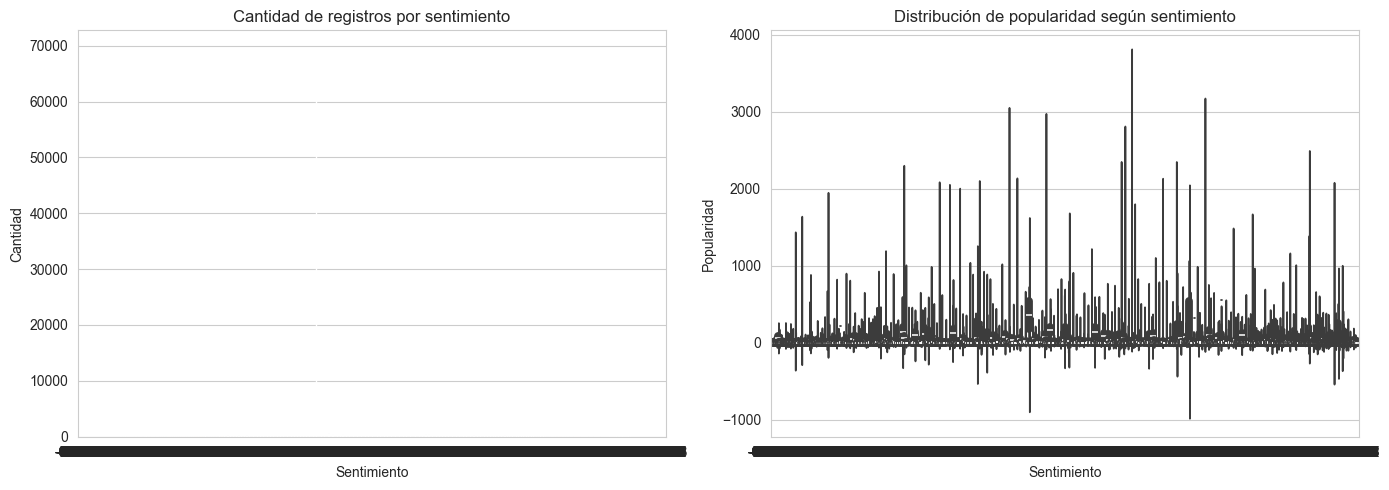

In [6]:
# Configuración de estilo
sns.set_style("whitegrid")

# Figura y ejes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de conteo de sentimientos
sns.countplot(x="sentimiento", data=tmdb, palette="Set2", ax=axes[0])
axes[0].set_title("Cantidad de registros por sentimiento")
axes[0].set_xlabel("Sentimiento")
axes[0].set_ylabel("Cantidad")

# Gráfico de distribución de popularidad por sentimiento
sns.violinplot(x="sentimiento", y="Popularidad", data=tmdb, palette="muted", ax=axes[1])
axes[1].set_title("Distribución de popularidad según sentimiento")
axes[1].set_xlabel("Sentimiento")
axes[1].set_ylabel("Popularidad")

# Mostrar gráficos
plt.tight_layout()
plt.show()

## worldcloud

Para comprender mejor los patrones lingüísticos asociados con los distintos sentimientos en las descripciones de los programas, se han generado nubes de palabras para cada categoría: positivo, neutro y negativo. Estas visualizaciones permiten identificar las palabras más frecuentes en cada grupo, proporcionando una visión general sobre qué términos suelen estar asociados con descripciones optimistas, neutrales o críticas.

In [25]:
def generar_nube(texto, titulo):
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo)
    plt.show()


In [27]:
sentimientos = ["positive", "neutral", "negative"]

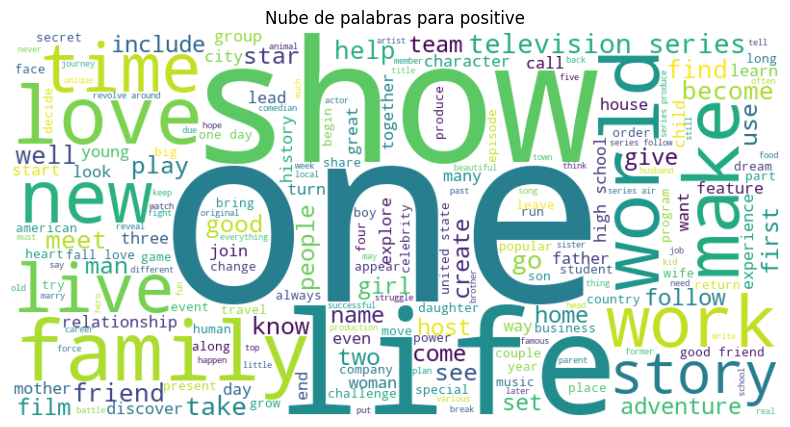


Top 5 palabras más usadas en sentimiento positive:
series: 18622
show: 14241
life: 9812
love: 8768
one: 7794


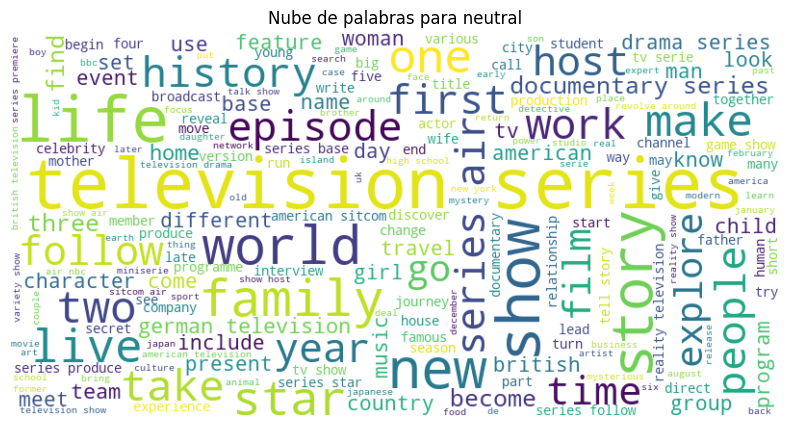


Top 5 palabras más usadas en sentimiento neutral:
series: 4226
show: 2209
television: 2116
air: 1407
life: 1303


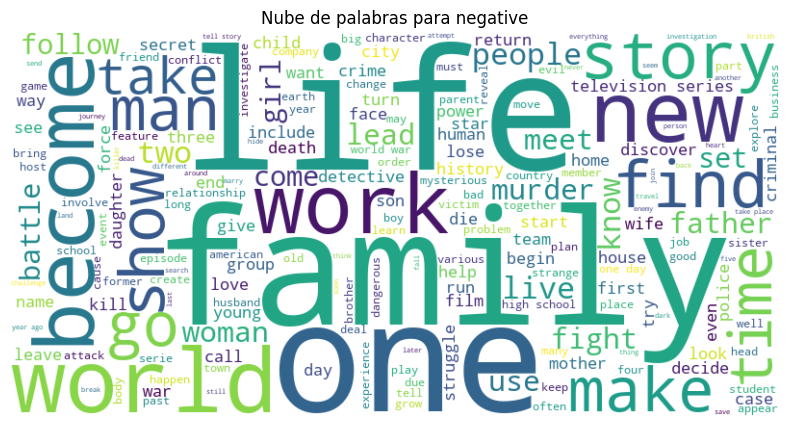


Top 5 palabras más usadas en sentimiento negative:
series: 6379
life: 4478
one: 3544
world: 3298
show: 3174


In [36]:


for sentimiento in sentimientos:
    texto_filtrado = " ".join(tmdb[tmdb["sentimiento"] == sentimiento]["Resumen_procesado"].dropna().astype(str))  # Usa la columna preprocesada
    generar_nube(texto_filtrado, f"Nube de palabras para {sentimiento}")
    palabras = texto_filtrado.split()
    
    # Contar frecuencia de palabras
    contador = Counter(palabras)
    
    # Obtener las 5 palabras más frecuentes
    palabras_comunes = contador.most_common(5)
     
    print(f"\nTop 5 palabras más usadas en sentimiento {sentimiento}:")
    for palabra, frecuencia in palabras_comunes:
        print(f"{palabra}: {frecuencia}")


Se puede observar que las palabras mas utilizadas en los resumenes independiente del sentimiento son series, show y life. <br>
La palabra series lidera los tres rankings, indicando que la estructura del contenido televisivo es la mas representativa dentro de la base de datos.<br>
Con respecto a show, no es sorpresa que se refieran a si mismo como show, ya sea una serie, pelicula o docuemntal, que corresponden sobre el 90% de los presentes en la base.<br>
Por otro lado, life aparece con una alta frecuencia en todas las categorías, lo que sugiere que muchas producciones televisivas, ya sean dramáticas, cómicas o documentales, giran en torno a la experiencia humana. Sin embargo, la presencia de love en el sentimiento positivo y world en el negativo indica que las emociones se diferencian más a partir de palabras específicas asociadas a sentimientos que del lenguaje general de la industria.<br>


## 

## Deep Learning

Primer lugar se debe hacer el preprocesamiento:
<br>Tokenizar y Padding para convertir el texto en vectores de entrada.
<br>Normalizar las variables numéricas y se codificar las categóricas.

In [4]:
tmdb = tmdb.dropna(subset=["Resumen_procesado", "num_Generos", "Tipo_Show", "sentimiento","Popularidad"])

In [7]:
MAX_VOCAB = 10000  # Máximo número de palabras en el vocabulario
MAX_LENGTH = 100  # Longitud máxima de cada secuencia
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(tmdb["Resumen_procesado"])
sequences = tokenizer.texts_to_sequences(tmdb["Resumen_procesado"])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding="post")

In [10]:
label_encoder = LabelEncoder()
tmdb["tipo_show_encoded"] = label_encoder.fit_transform(tmdb["Tipo_Show"])
tmdb["sentimiento_encoded"] = label_encoder.fit_transform(tmdb["sentimiento"])


In [12]:
scaler = MinMaxScaler()
tmdb["num_generos_norm"] = scaler.fit_transform(tmdb[["num_Generos"]])
tmdb["Popularidad_norm"] = scaler.fit_transform(tmdb[["Popularidad"]])

Definimos las variables de entrada y salida, ademas de separa en test y entrenamiento

In [13]:
X_text = padded_sequences
X_numeric = tmdb[["num_generos_norm", "tipo_show_encoded","sentimiento_encoded"]].values
y = tmdb["Popularidad_norm"].values
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42
)

definimos las capas ocultas

In [14]:
vocab_size = MAX_VOCAB  
embedding_dim = 64  
text_input = tf.keras.Input(shape=(MAX_LENGTH,))
text_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(text_input)
text_lstm = LSTM(64, return_sequences=True)(text_embedding)
text_lstm = LSTM(32)(text_lstm)

num_input = tf.keras.Input(shape=(X_numeric.shape[1],))
merged = tf.keras.layers.concatenate([text_lstm, num_input])

dense1 = Dense(64, activation="relu")(merged)
dropout1 = Dropout(0.3)(dense1)
dense2 = Dense(32, activation="relu")(dropout1)
output = Dense(1, activation="linear")(dense2)

model = tf.keras.Model(inputs=[text_input, num_input], outputs=output)

In [15]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [16]:
model.fit(
    [X_train_text, X_train_num], y_train,
    epochs=10, batch_size=32, validation_data=([X_test_text, X_test_num], y_test)
)


Epoch 1/10
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 114s 57ms/step - loss: 2202.0364 - mae: 22.5601 - val_loss: 0.0186 - val_mae: 0.1281
Epoch 2/10
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 111s 58ms/step - loss: 7.3533 - mae: 1.0974 - val_loss: 0.0081 - val_mae: 0.0865
Epoch 3/10
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 108s 56ms/step - loss: 1.7962 - mae: 0.6377 - val_loss: 0.0257 - val_mae: 0.1452
Epoch 4/10
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 109s 57ms/step - loss: 1.3387 - mae: 0.6278 - val_loss: 0.1641 - val_mae: 0.3669
Epoch 5/10
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 109s 57ms/step - loss: 0.8425 - mae: 0.4940 - val_loss: 0.0039 - val_mae: 0.0568
Epoch 6/10
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 109s 56ms/step - loss: 0.2882 - mae: 0.3117 - val_loss: 0.1285 - val_mae: 0.3272
Epoch 7/10
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 111s 58ms/step - loss: 0.1189 - mae: 0.2009 - val_loss: 0.0730 - val_mae: 0.2411
Epoch 8/10
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 112s 58ms/step - loss: 0.0277 - mae: 0.0871 - val_loss: 0.0017 - val_mae: 0.0356
Epoch 9/10
1

In [17]:
loss, mae = model.evaluate([X_test_text, X_test_num], y_test)
print(f"Error cuadrático medio: {loss:.4f}, Error absoluto medio: {mae:.4f}")


482/482 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 2.7837e-04 - mae: 0.0087
Error cuadrático medio: 0.0003, Error absoluto medio: 0.0086


In [ ]:
# Obtener predicciones del modelo
y_pred = model.predict([X_test_text, X_test_num])

# Graficar los valores reales vs los predichos
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', linewidth=2, label="Ideal")
plt.xlabel("Popularidad real")
plt.ylabel("Popularidad predicha")
plt.title("Comparación entre popularidad real y predicha")
plt.legend()
plt.show()